## Masked Autoencoders for Anomaly Detection

This demo shows how a trained MAE-AD model can detect anomalies in images. The model was trained according to the default instructions in the README file.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

from mae import models_mae

### Convenience functions

In [52]:
# define the utils
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])


def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def show_map(m, title=""):
    assert len(m.shape) == 2
    img = plt.imshow(m, cmap="viridis")
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.colorbar(img, orientation="vertical", fraction=0.05, pad=0.02)
    plt.show()
    return


def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    pprint(msg)
    print(f"Model has inference mask ratio {model.inference_mask_ratio}")
    return model


def run_one_image(img, model, threshold=0.5):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    result = model.inference(x.float(), threshold=threshold)
    pprint(result)
    x = torch.einsum('nchw->nhwc', x)
    y = result["preds"]
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    loss_maps = result["loss_maps"].detach().cpu()

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 3, 1)
    show_image(x[0].detach().cpu(), "original")

    plt.subplot(1, 3, 2)
    show_image(y[0].detach().cpu(), "reconstruction")

    plt.subplot(1, 3, 3)
    show_map(loss_maps[0].detach().cpu(), "loss map")

    plt.show()
    return result

### Load a trained MAE-AD model

In [9]:
import os

chkpt_dir = "../output_p7_ep4000/checkpoint-3999.pth"
assert os.path.exists(chkpt_dir)
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch7')

<All keys matched successfully>
Model has inference mask ratio 0.25


### Load and visualise an image

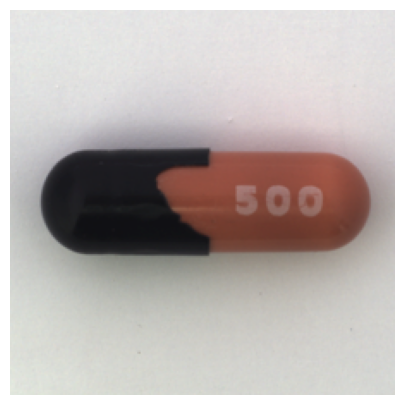

In [54]:
# Play around with different defects
# img = Image.open("../data/capsule/test/good/010.png")
img = Image.open("../data/capsule/test/bad/crack_010.png")
# img = Image.open("../data/capsule/test/bad/squeeze_010.png")
# img = Image.open("../data/capsule/test/bad/scratch_010.png")
# img = Image.open("../data/capsule/test/bad/poke_010.png")
# img = Image.open("../data/capsule/test/bad/print_010.png")

img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Run MAE on the image

MAE with pixel reconstruction:
{'anomaly_scores': 1.9907745122909546,
 'decisions': True,
 'images': tensor([[[[1.8037, 1.7865, 1.7865,  ..., 1.7523, 1.7523, 1.7352],
          [1.7523, 1.8037, 1.8208,  ..., 1.7523, 1.7865, 1.7180],
          [1.7865, 1.8379, 1.7865,  ..., 1.7180, 1.7352, 1.7352],
          ...,
          [1.8208, 1.7865, 1.7865,  ..., 1.5125, 1.5468, 1.5639],
          [1.7523, 1.7352, 1.7352,  ..., 1.5297, 1.5639, 1.5297],
          [1.7523, 1.7009, 1.7523,  ..., 1.5639, 1.4954, 1.5297]],

         [[1.9384, 2.0084, 1.9734,  ..., 1.9209, 1.9209, 1.8683],
          [1.9384, 2.0084, 1.9559,  ..., 1.9209, 1.9559, 1.8508],
          [1.9734, 1.9384, 1.9384,  ..., 1.8859, 1.9384, 1.8859],
          ...,
          [2.0609, 2.0259, 2.0434,  ..., 1.7108, 1.6933, 1.7458],
          [1.9909, 1.9909, 1.9909,  ..., 1.7458, 1.6933, 1.6933],
          [2.0084, 2.0084, 1.9909,  ..., 1.7458, 1.7108, 1.6933]],

         [[2.1171, 2.1868, 2.1868,  ..., 2.1694, 2.1520, 2.1694],
       

C:\Users\lucfr\AppData\Local\Temp\ipykernel_102152\3500297365.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(img)


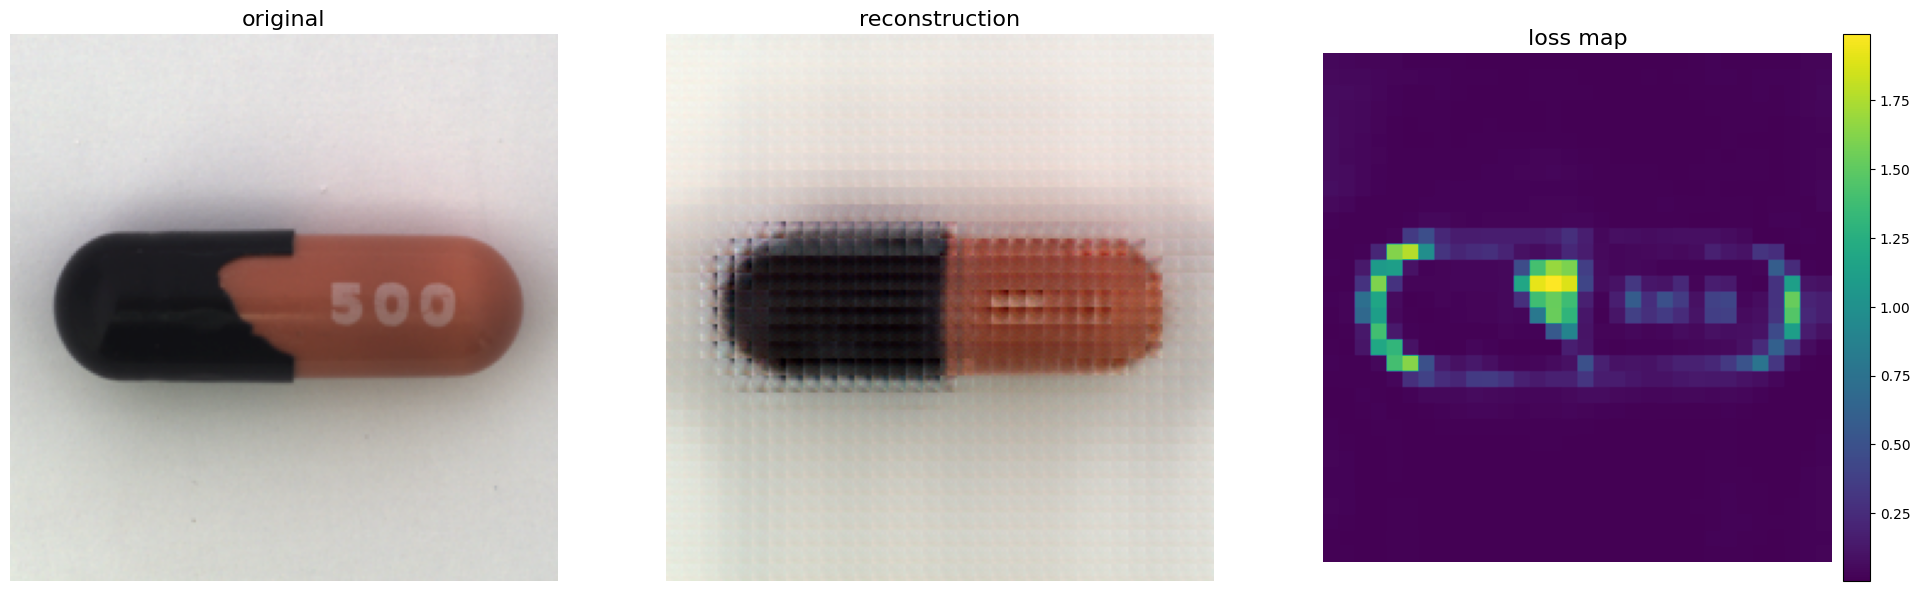

In [55]:
# %autoreload 2 
# from mae import models_mae

print('MAE with pixel reconstruction:')
result = run_one_image(torch.tensor(img, device="cuda"), model_mae.to("cuda"), threshold=0.75)

(array([23814., 11417.,  3871.,  1813.,  1372.,  1470.,   735.,   735.,
          637.,   392.,   245.,   196.,   343.,   392.,   343.,    98.,
          245.,   147.,   196.,   147.,    49.,    49.,    98.,    98.,
           49.,    98.,    49.,     0.,    49.,    49.,    49.,     0.,
            0.,     0.,    49.,    98.,     0.,     0.,     0.,    49.,
            0.,     0.,     0.,    49.,    49.,    49.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,    98.,    98.,     0.,    98.,     0.,     0.,
            0.,    49.,     0.,    98.,     0.,     0.,     0.,     0.,
           49.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           49.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,    49.]),
 array([0.00343544, 0.02018589, 0.03693634, 0.0536868 , 0.07043725,
        0.0871877 , 0.1039

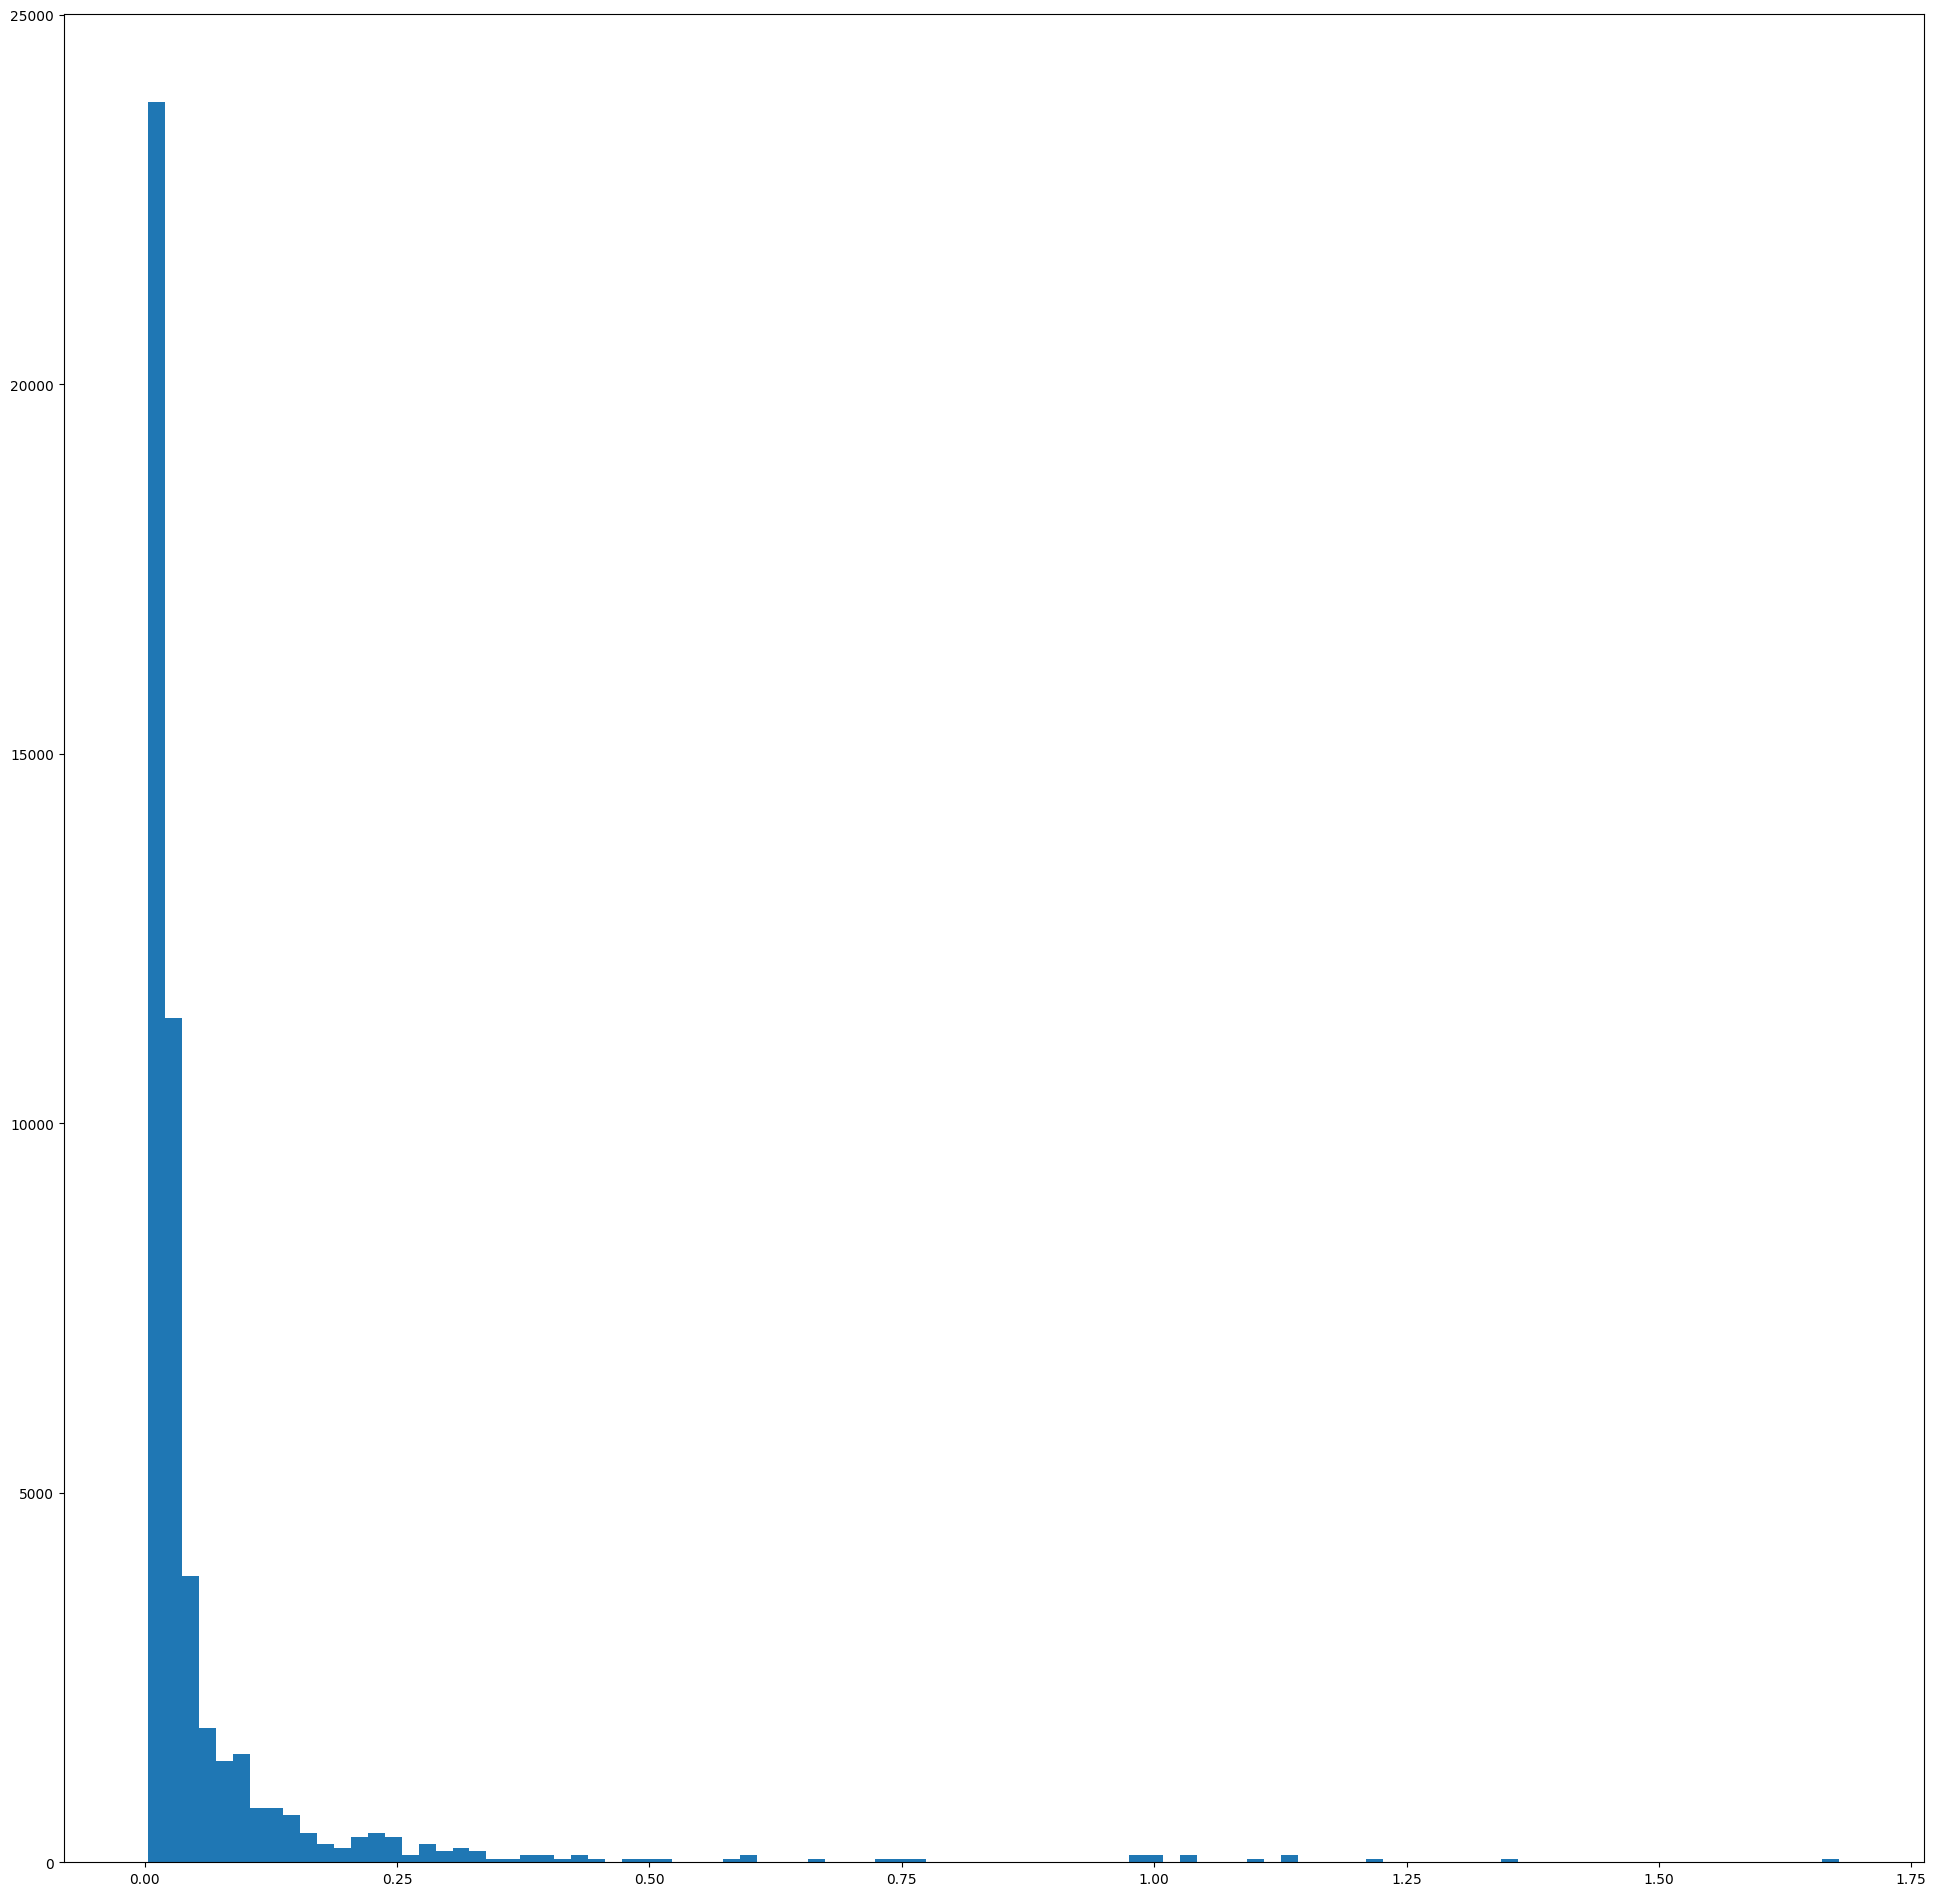

In [51]:
plt.hist(result["loss_maps"].flatten(), bins=100)